In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [89]:
google_df = pd.read_csv('data/google_stock_2010-22.csv')

In [90]:
google_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,15.689439,15.753504,15.621622,15.684434,15.684434,78169752
1,2010-01-05,15.695195,15.711712,15.554054,15.615365,15.615365,120067812
2,2010-01-06,15.662162,15.662162,15.174174,15.221722,15.221722,158988852
3,2010-01-07,15.250250,15.265265,14.831081,14.867367,14.867367,256315428
4,2010-01-08,14.814815,15.096346,14.742492,15.065566,15.065566,188783028


In [91]:
google_df['Date'] = pd.to_datetime(google_df['Date'])

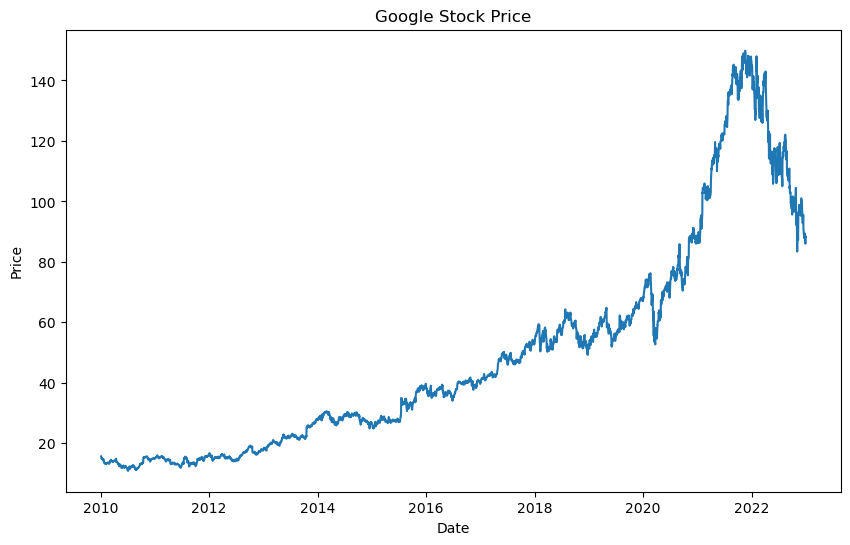

In [92]:
fig = plt.figure(figsize=(10, 6))
plt.plot(google_df['Date'], google_df['Close'])
plt.title('Google Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [93]:
# show trend and seasonality and residuals all three
from statsmodels.tsa.seasonal import seasonal_decompose

In [94]:
result = seasonal_decompose(google_df['Close'], model='additive', period=30)

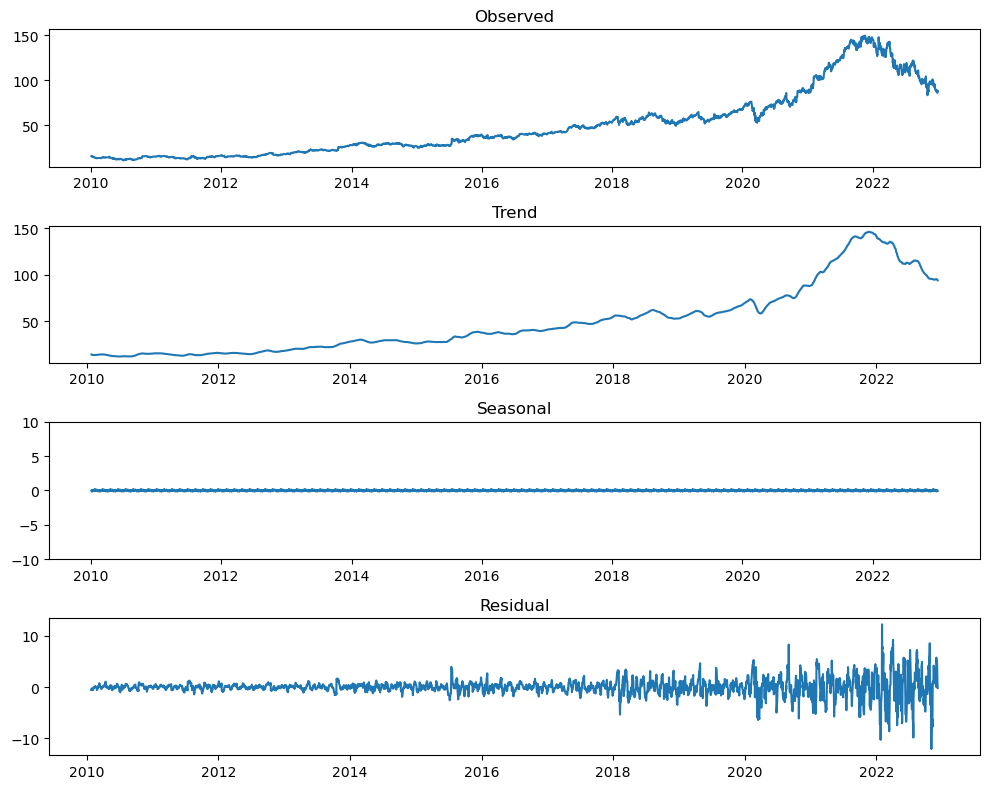

In [95]:
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
axes[0].plot(google_df['Date'], result.observed)
axes[0].set_title('Observed')
axes[1].plot(google_df['Date'], result.trend)
axes[1].set_title('Trend')
axes[2].plot(google_df['Date'], result.seasonal)
axes[2].set_ylim(-10, 10)
axes[2].set_title('Seasonal')
axes[3].plot(google_df['Date'], result.resid)
axes[3].set_title('Residual')
plt.tight_layout()
plt.show()

In [96]:
# moving averages
google_df['MA_10'] = google_df['Close'].rolling(window=10).mean()
google_df['CMA_10'] = google_df['Close'].rolling(window=10, center=True).mean()

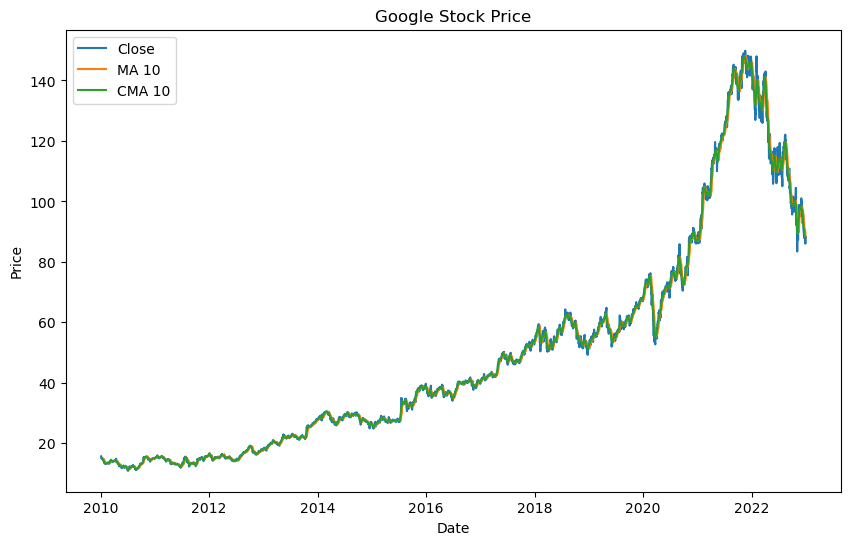

In [97]:
fig = plt.figure(figsize=(10, 6))
plt.plot(google_df['Date'], google_df['Close'], label='Close')
plt.plot(google_df['Date'], google_df['MA_10'], label='MA 10')
plt.plot(google_df['Date'], google_df['CMA_10'], label='CMA 10')
plt.title('Google Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

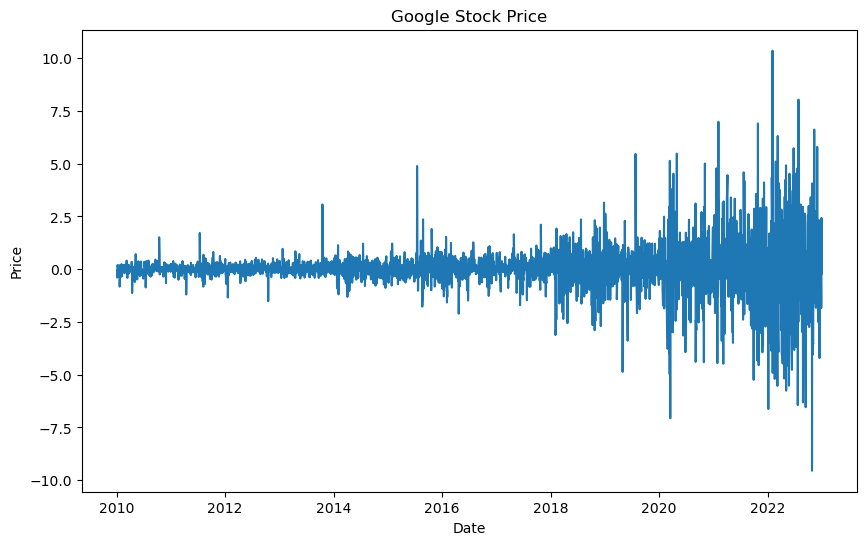

In [98]:
# differencing
google_df['Close_diff'] = google_df['Close'].diff()

fig = plt.figure(figsize=(10, 6))
plt.plot(google_df['Date'], google_df['Close_diff'])
plt.title('Google Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [99]:
# adf test for stationarity on differenced data
from statsmodels.tsa.stattools import adfuller

result = adfuller(google_df['Close_diff'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -13.143871907569668
p-value: 1.4112618457202534e-24


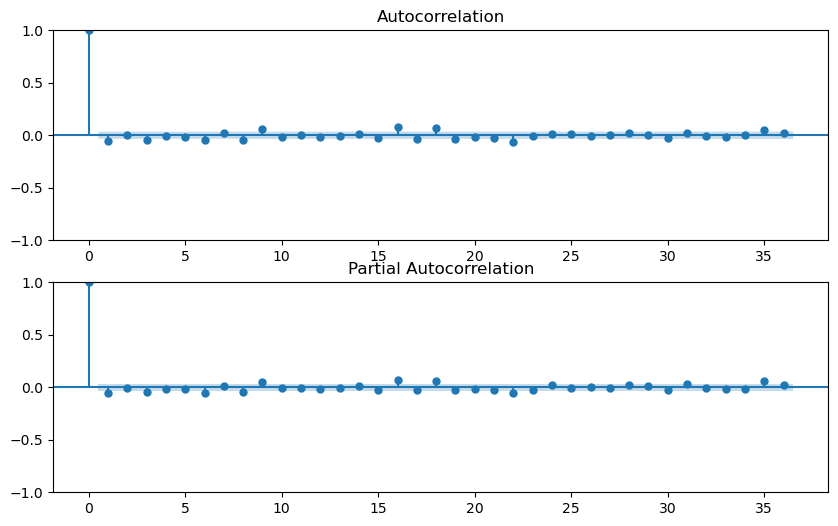

In [100]:
# acf and pacf test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(google_df['Close_diff'].dropna(), ax=axes[0])
plot_pacf(google_df['Close_diff'].dropna(), ax=axes[1])
plt.show()

In [101]:
# arima(0, 1, 0)
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(google_df['Close'], order=(2, 1, 2))
model_fit = model.fit()
print(model_fit.summary())  

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3272
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -5027.046
Date:                Tue, 24 Sep 2024   AIC                          10064.092
Time:                        07:40:19   BIC                          10094.556
Sample:                             0   HQIC                         10075.001
                               - 3272                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2648      0.217      1.218      0.223      -0.161       0.691
ar.L2          0.4049      0.145      2.795      0.005       0.121       0.689
ma.L1         -0.3317      0.220     -1.508      0.1

In [102]:
# forecast for next 1 year and show the plot 
forecast = model_fit.forecast(steps=252)

In [103]:
# forecast is on differenced data, so we need to add the last value of original data
# forecast = forecast + google_df['Close'].iloc[-1]

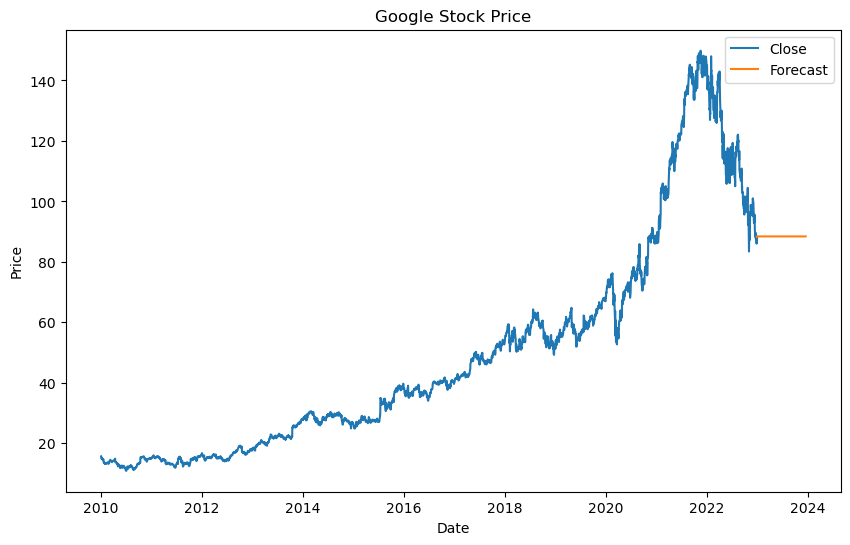

In [104]:
fig = plt.figure(figsize=(10, 6))
plt.plot(google_df['Date'], google_df['Close'], label='Close')
plt.plot(pd.date_range(start=google_df['Date'].iloc[-1], periods=252, freq='B'), forecast, label='Forecast')
plt.title('Google Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

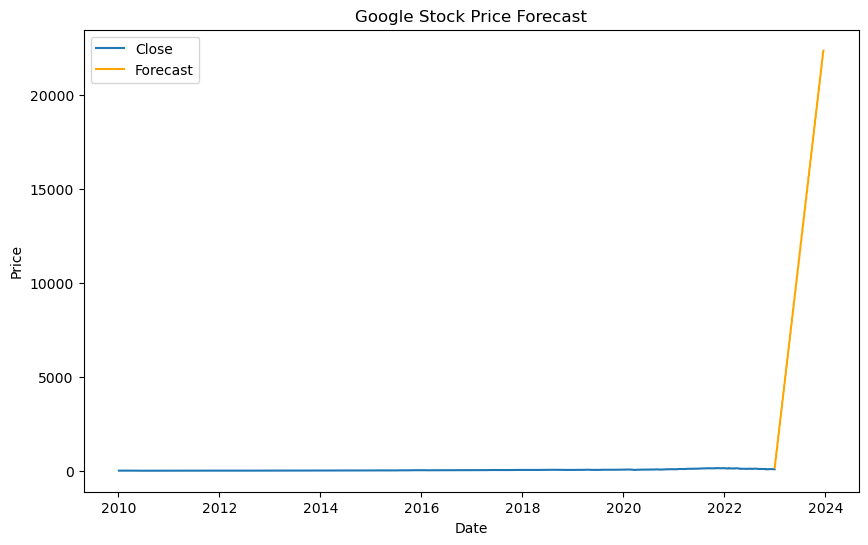

In [106]:
# Forecast for the differenced data (252 steps into the future)
forecast_diff = model_fit.forecast(steps=252)

# Reverse differencing to get back to original scale
# Start from the last observed value in the original data
last_observed_value = google_df['Close'].iloc[-1]

# Convert the differenced forecast back to the original scale
forecast_original_scale = forecast_diff.cumsum() + last_observed_value

# Generate correct date range for the forecasted values
forecast_dates = pd.date_range(start=google_df['Date'].iloc[-1], periods=252, freq='B')

# Plot
fig = plt.figure(figsize=(10, 6))
plt.plot(google_df['Date'], google_df['Close'], label='Close')
plt.plot(forecast_dates, forecast_original_scale, label='Forecast', color='orange')
plt.title('Google Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
